# Implementing Long Short Term Memory with Keras

## Loading and Visualizing Data

In [128]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [129]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andreazzini/international-airline-passengers")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'international-airline-passengers' dataset.
Path to dataset files: /kaggle/input/international-airline-passengers


In [130]:
data = pd.read_csv(path+'/international-airline-passengers.csv',skipfooter=5, engine='python') # The last 5 data was contaminated
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


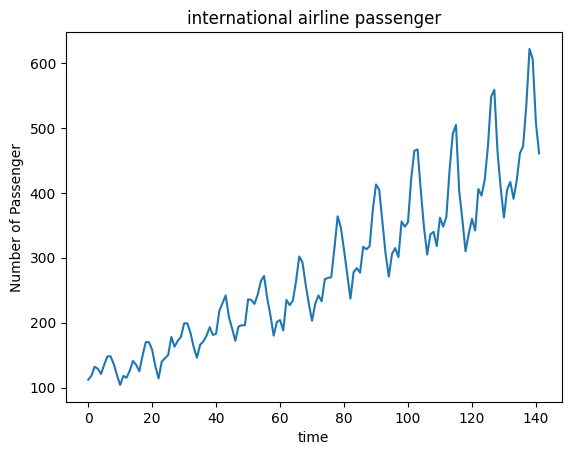

In [131]:
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("Number of Passenger")
plt.title("international airline passenger")
plt.show()

## Preprocessing Data
Reshape

Change type

Scaling

Train test split

Create dataset

In [132]:
# LSTM expects 2D or 3D input
dataset = dataset.reshape(-1,1) # outputs a column with many rows
dataset = dataset.astype("float32")
dataset.shape

(142, 1)

In [133]:
# scaling
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [134]:
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 71, test size: 71 


In [135]:
time_stemp = 10 # Use the previous 10 time steps to predict the next value

dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = numpy.array(dataX)
trainY = numpy.array(dataY)

In [136]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = numpy.array(dataX)
testY = numpy.array(dataY)

In [137]:
trainX.shape

(60, 10)

In [138]:
# LTSM expects shape: (samples, timesteps, features)
trainX = numpy.reshape(trainX, (trainX.shape[0], time_stemp, 1))
testX = numpy.reshape(testX, (testX.shape[0], time_stemp, 1))
"Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features"

'Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features'

## Create LSTM Model

In [139]:
## Model's layer breakdown:
# Input layer: shape (1, 10)
# LSTM layer:
#   10 memory cells (neurons)
#   Learns temporal dependencies
# Dense layer:
#   Outputs a single value (next passenger count)

model = Sequential()
model.add(Input(shape=(time_stemp, 1)))
model.add(LSTM(10))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0115
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 16/50
60/60 

## Predictions and Visualising LSTM Model

In [140]:
from sklearn.metrics import mean_absolute_error
# Predictions are scaled in 0–1 range:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions - back to actual passenger numbers
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error to measure average prediction error (lower is better)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainMAE = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainMAE))
testMAE = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testMAE))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train Score: 19.10 RMSE
Test Score: 51.29 RMSE
Train Score: 15.47 MAE
Test Score: 38.64 MAE


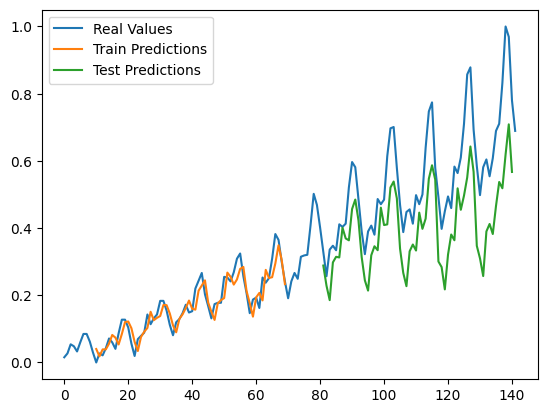

In [117]:
# shifting train
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = "Real Values")
plt.plot(trainPredictPlot, label = "Train Predictions")
plt.plot(testPredictPlot, label = "Test Predictions")
plt.legend()
plt.show()

## Assignment


1) Examin the original notebook. Identify why timesteps=1 is unusual and explain how to choose time_stemp properly!
2) Try different window sizes (e.g., 5, 15) and explain impact.
3) Why normalization matters for neural networks?
4) Experiment with number of neurons (5, 10, 20) and activation functions. Explain impact!
5) Train with different batch sizes and epochs. Explain impact!
6) If there is a different evaluation metric, try that!

Advanced:

7) Predict multiple months ahead (e.g., next 3 months) instead of one.
8) Improve performance with Dropout or multiple LSTM layers.
9) Predict next 12 months and plot the forecast.

1. time_stemp = 1 meaning predict the next value using only one previous value which is not the purpose of LSTM where it need to predict the trend based on past values like It cannot capture seasonality(Yearly or monthly).

How to choose:
For Financial time series data
30 days - captures monthly cycles
60 days - captures quarterly patterns
90 - 120 days - captures medium-term trends

For this data set (airline passengers):
the model needs at least 12 timesteps to see one full cycle.
12 - one year
24 - two years
36 - 3 years

2. Original Window Size (time_stemp = 10):
The model looks at the previous 10 months to predict the next month.
Impact
Captures some short term trend
Misses the full yearly seasonality (12 month cycle)
Predictions follow the general trend but lag behind yet balanced model
RMSE is moderate ( ~21 train, ~56 test)

Window Size = 5 (Short Window)
Only the previous 5 months.
Impact
Model becomes very reactive
Captures only short term fluctuations
Fails to learn seasonal patterns
Predictions become noisy and less stable
Train RMSE: 22.18  
Test RMSE: 62.56

Window Size = 15 (Overfitting)
Train RMSE: 20.78  
Test RMSE: 109.09
Impact
It shows Lowest training error and Worst test error, looks like Model memorizes training data which Predictions diverge from real values
Severe overfitting


3. Normalization matters for neural networks because it directly affects how well, how fast, and how reliably the model learns.
-Prevents exploding and vanishing gradients
-Makes training faster and smoother
-Helps the model learn patterns instead of magnitudes
-Normalization is essential to use Activation function
-Normalization required for inverse transformation

4. Impact of 5 Neurons + ReLU Activation:

With only 5 neurons, the LSTM has extremely limited capacity.It cannot learn the upward trend and the yearly seasonality and also repeating monthly patterns
Due to this the predictions collapse into a constant flat line.

5 neurons = too few parameters and the model cannot store enough temporal information.
ReLU is not recommended for LSTMs because it outputs zero for negative inputs. It can produce exploding values for large inputs. It does not handle smooth temporal transitions well

20 Neurons (High Capacity) Model becomes more powerful which learns training data extremely well but generalizes poorly, Overfits quickly

The behavior on RMSE for training is very low and for Test RSME is very high, Predictions diverge from real values


5. Impact of Batch Size = 5 and Epochs = 50:
LSTM with batch size = 5 and 50 epochs is actually a very reasonable configuration for a small time‑series dataset like the airline passengers dataset
Your RMSE values:
Train RMSE ≈ 26.33
Test RMSE ≈ 61.47
Provides stable gradients (less noisy than batch=1).
Still small enough to capture fine‑grained temporal patterns.
Faster training than batch=1.
Reduces the risk of exploding/vanishing gradients.
Often improves generalization for small datasets

Impact of Batch Size = 1 and Epochs = 100:
with batch size = 1 and 100 epochs is one of the most aggressive training configurations can use for an LSTM on a small dataset.

The model updates weights after every single sample.Gradients are very noisy.Learning is slow but extremely detailed. The model can capture fine grained temporal patterns

Often gives excellent fit on small datasets but training becomes unstable

Training RMSE becomes very low (as observed: 0.03 RMSE).
Model begins to memorize the training data
Test RMSE increases (result: 0.21 RMSE, still good but higher)

6. Evaluation Metrics (RMSE & MAE)
RMSE and MAE help measure how close the model predictions are to the actual values.
RMSE penalizes large errors more strongly, making it useful for detecting big mistakes in forecasting.
MAE gives the average absolute difference between predicted and real values, making it easier to interpret in practical terms.

Impact of Epochs = 100 and Batch Size = 1:
Train RMSE: 0.03
Test RMSE: 0.17
Train MAE: 0.03
Test MAE: 0.15

Even though the model learned the training data extremely well, the test RMSE = 0.17 and test MAE = 0.15 show that, the model generalizes well and overfitting is present but controlled and predictions follow the real values closely

Impact of Epochs = 50 and Batch Size = 1:
Train RMSE: 19.10
Test RMSE: 51.29
Train MAE: 15.47
Test MAE: 38.64
Based on new metric(MAE) On the training data,the predictions are off by about 15 passengers on average
On the test data, the predictions are off by about 38 passengers on average

The model fits the training data reasonably well, The test error is higher and some overfitting, But the model still performs decently on unseen data

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook